In [1]:
# This notebook produces the plots for the differential cross section results in the paper. In addition, one can plot a decomposed norm-shape covariance matrix.
# Prerequisites:
# 1) Systematic uncertainty toys, in the format of FoldedSysRecoEnergy"+str(energy)+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+Alpha+str(alpha)".npy"
# Where energy is the gaussian peak, rebin_factor is the width of bins, energy_width is the gaussian RMS and alpha is the regularisation parameter that's been used to construct the VF.
# 2) Statistical uncertainty toys, in the format of FoldedStatRecoEnergy"+str(energy)+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+alpha_string+".npy"
# 3) Distribution by modes, in the format of OmegaReco"+str(energy)+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+"Mode"+modes[i]+".npy"
# All of which can be produced using NumpyToysToMeasurements

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipynb.fs.full.CoefficientsCalcPlus import GetCoefficientsFlux
from ipynb.fs.full.CoefficientsCalcPlus import get_normalization
import sklearn.linear_model as linear_model
import scipy
import warnings; warnings.simplefilter('ignore')
import os
from matplotlib.pyplot import figure
import random as rnd
import matplotlib.ticker as ticker
import uproot4 as uproot
import scipy.stats
import seaborn as sns
import sklearn
from matplotlib.colors import Normalize

In [3]:
#Helper functions

def rebinned_bin_centers(nbins, xmin, xmax, factor):
    # Compute the bin widths for the original histogram
    bin_width = (xmax - xmin) / nbins
    
    # Compute the bin edges for the original histogram
    edges = np.linspace(xmin, xmax, nbins + 1)
    
    # Compute the new bin widths after rebinning
    new_bin_width = bin_width * factor
    
    # Compute the number of new bins
    new_nbins = int(nbins / factor)
    
    # Compute the bin edges for the rebinned histogram
    new_edges = np.linspace(xmin, xmax, new_nbins + 1)
    
    # Compute the bin centers for the rebinned histogram
    centers = (new_edges[1:] + new_edges[:-1]) / 2
    
    return centers

def slice_matrix(matrix, bounds):
    """
    Slice a matrix based on the given 4-tuple bounds.

    Args:
    matrix (list of lists): The input matrix.
    bounds (tuple): A 4-tuple (start_row, end_row, start_col, end_col) specifying the slice bounds.

    Returns:
    list of lists: The sliced submatrix.
    """
    start_row, end_row, start_col, end_col = bounds
    sliced_matrix = np.array([row[start_col:end_col] for row in matrix[start_row:end_row]])
    return sliced_matrix

In [4]:
# Adjustable parameters (user input)
energies = [625,750,875] #Gaussian peaks in MeV
rebin_factor = 40 #Bin widths
width = 70 #Gaussian RMS in MeV
modes_bool = True #Plot modes
folder_path = "../FluxTest/FlexibleUnfoldingResults/"

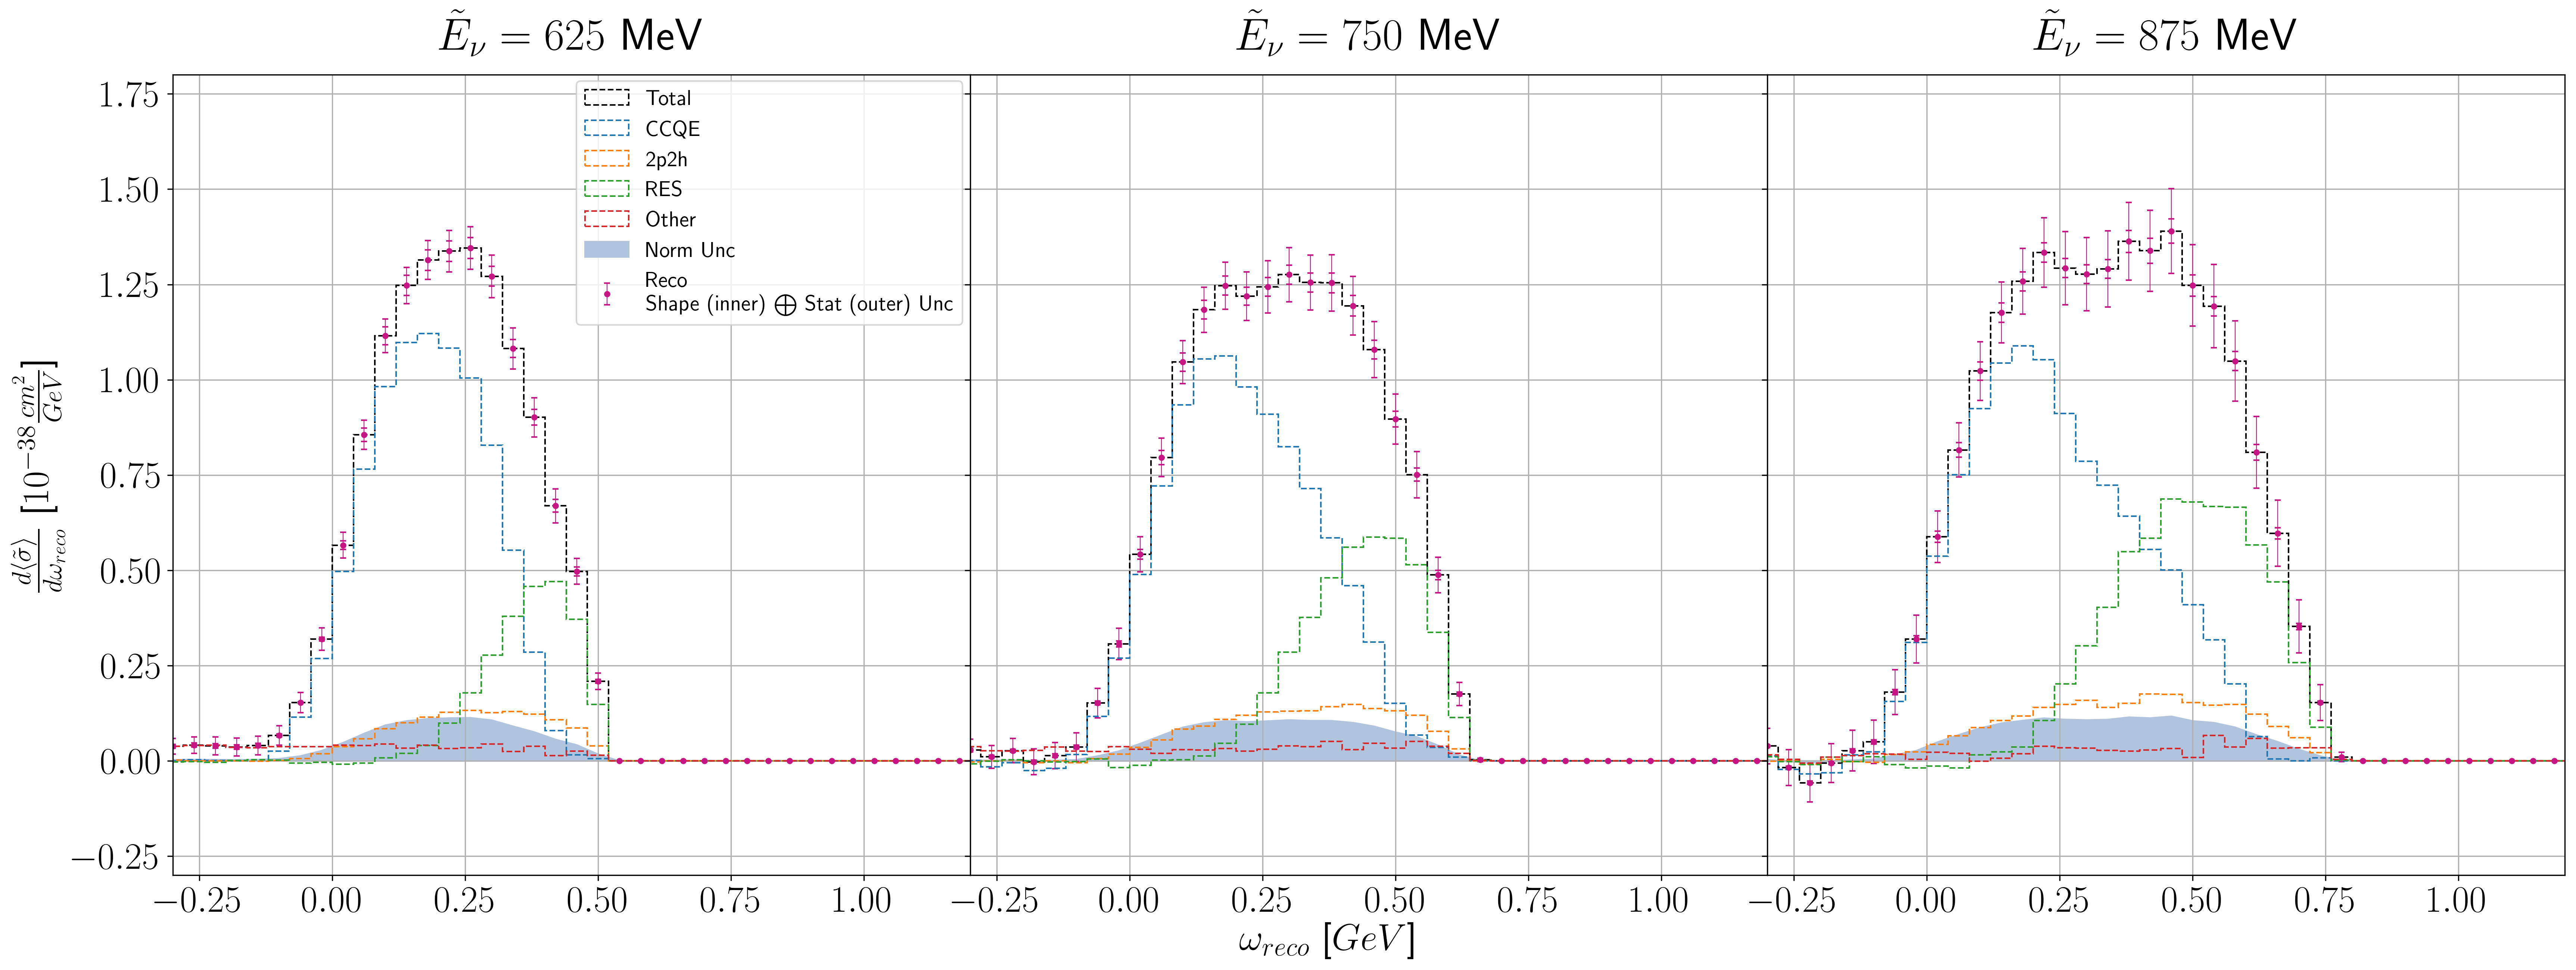

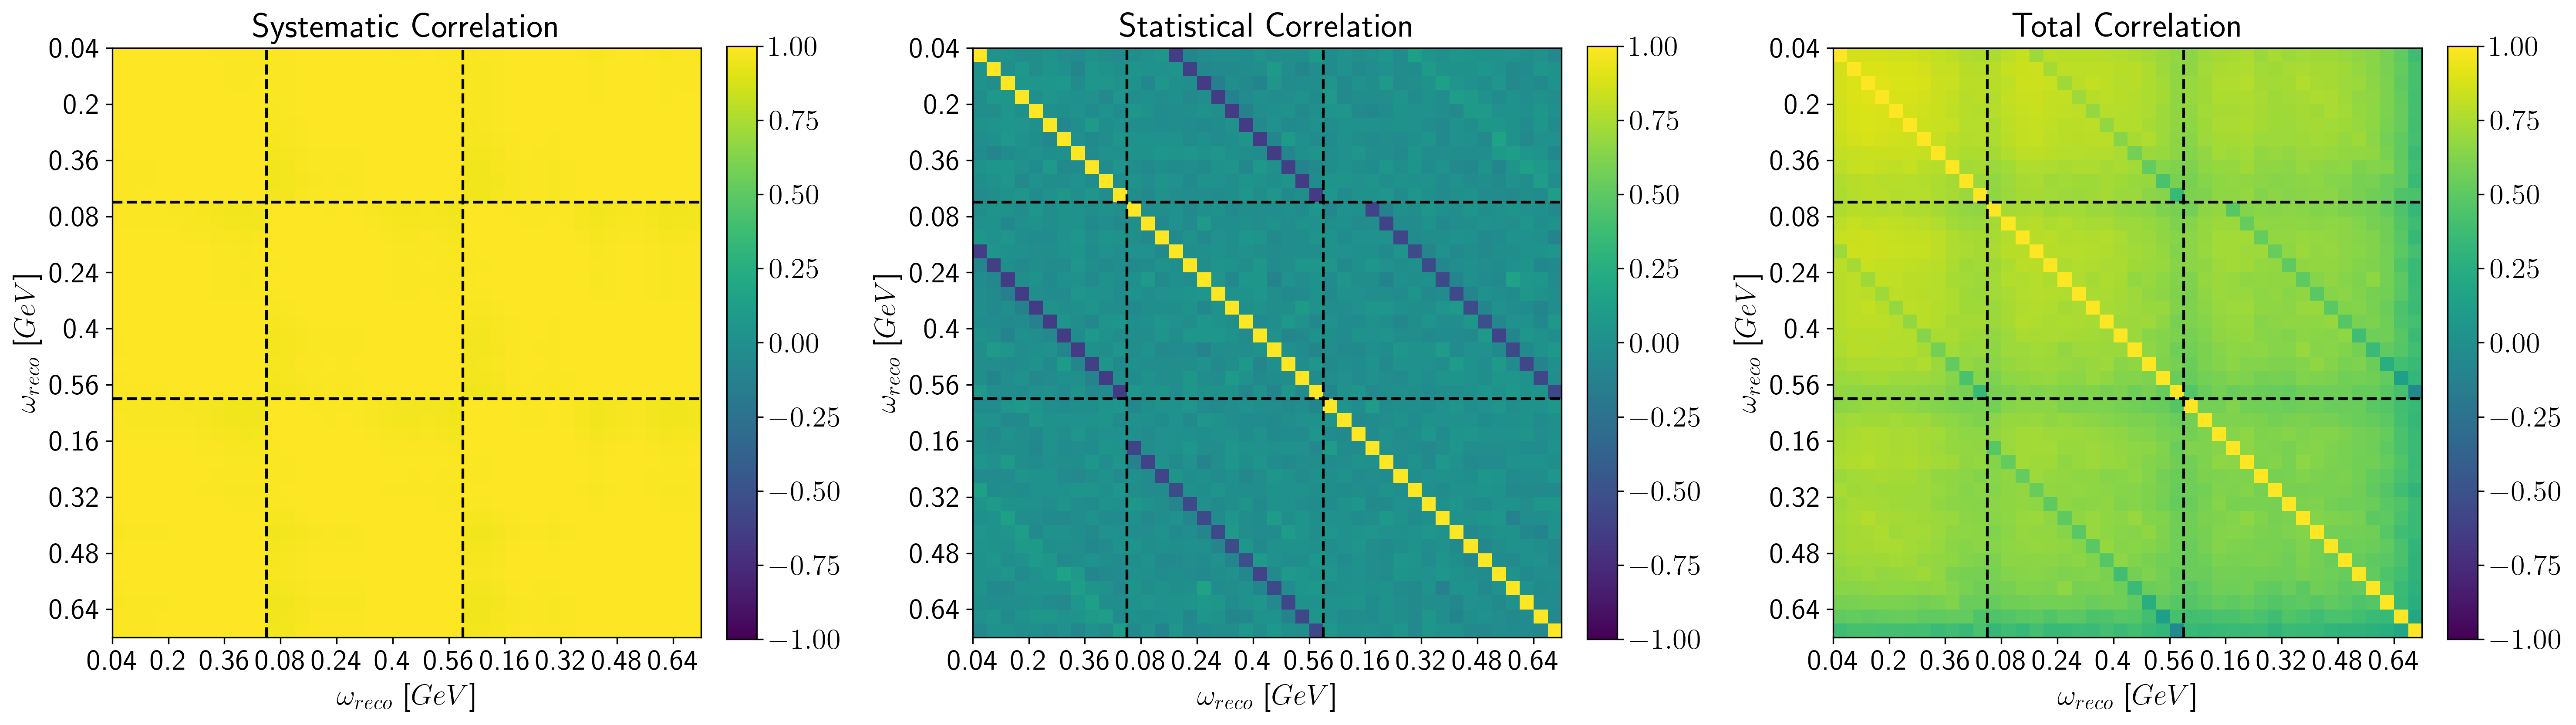

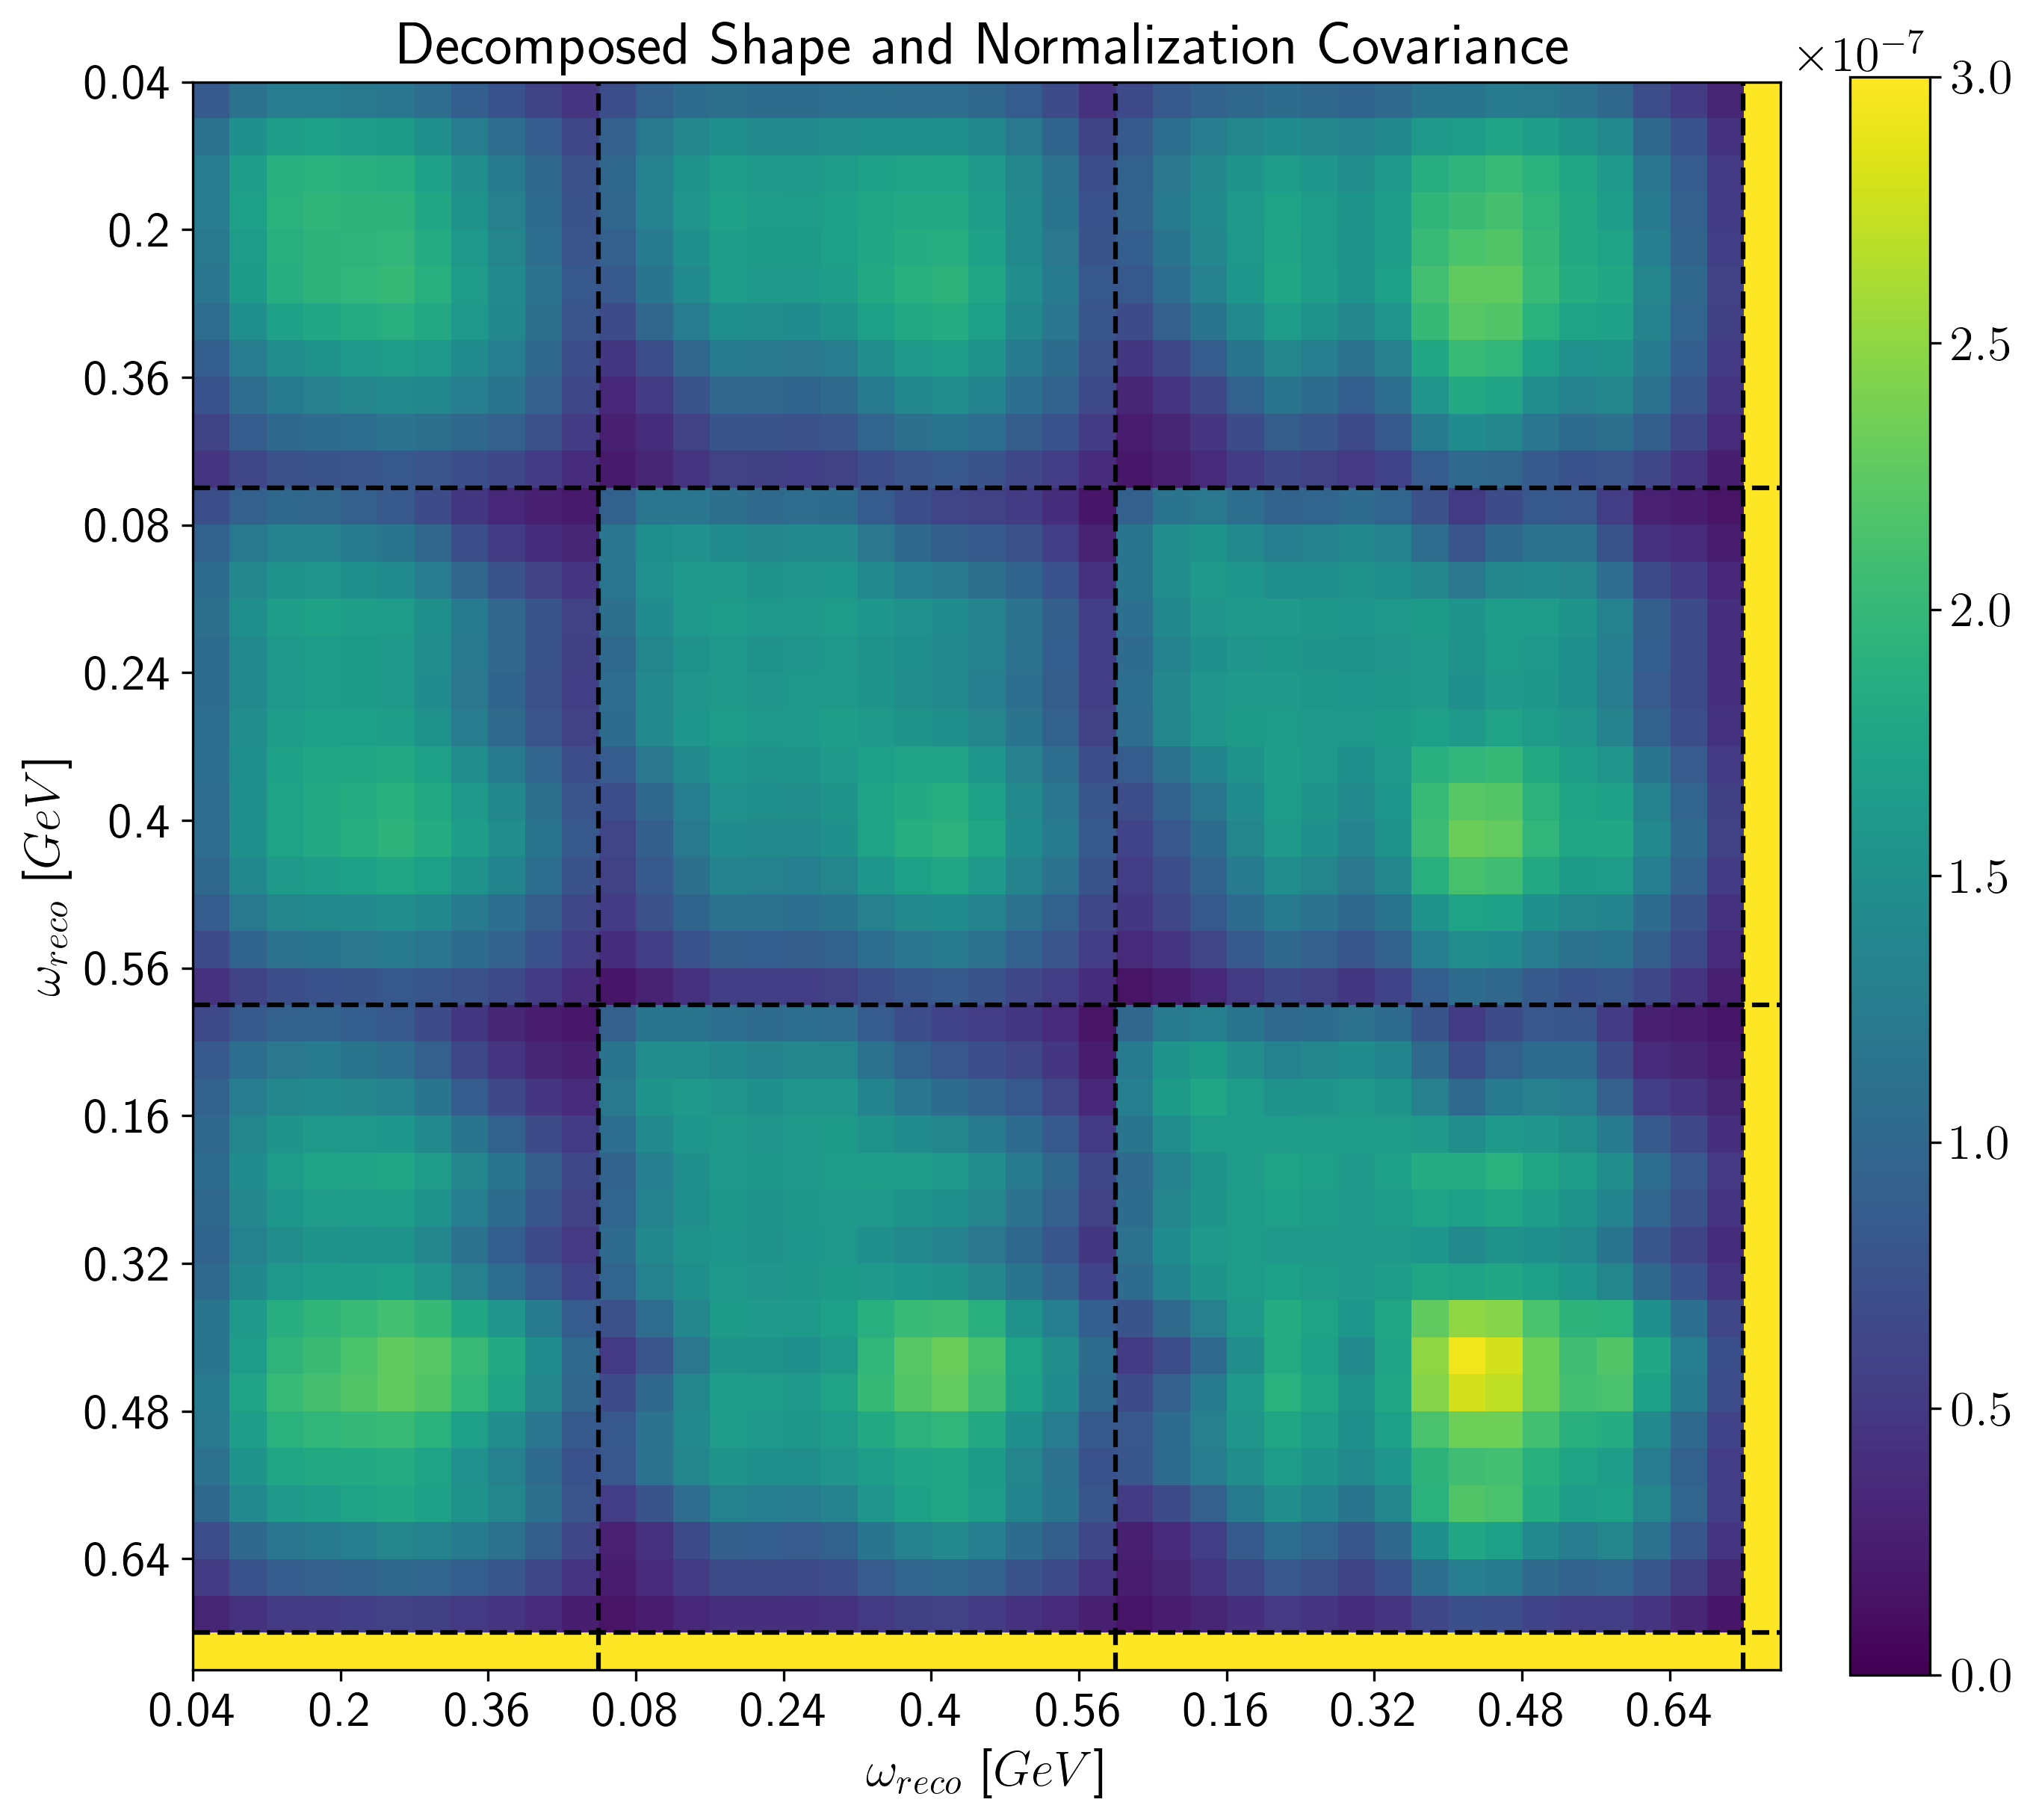

In [7]:
#Plot design
plt.rcParams['font.size'] = 24
plt.rcParams['text.usetex'] = True
col = 'mediumvioletred'
bbox_to_anchor = [0.393, 0.902]

## Data preparation
cv_array = []
shape_unc_array = []
stat_unc_array = []
stat_shape_unc_array = []
norm_unc_array = []

modes = ['CCQE','RES','2p2h','Other']
modes_arrays_array = []
flux_alpha = 1e-12
hist = True
alpha_string = "Alpha"+str(flux_alpha)

energy_bin_centers = rebinned_bin_centers(16000,-8000,8000,rebin_factor)/1000
centers = energy_bin_centers
centers_for_hist = centers-(1e-3*rebin_factor/2)

solutions_sys_array = []
solutions_stat_array = []
for energy_val in energies:
    energy = energy_val
    energy_width = width
    solutions_sys = np.load(folder_path+"FoldedSysRecoEnergy"+str(energy)+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+alpha_string+".npy")
    solutions_stat = np.load(folder_path+"FoldedStatRecoEnergy"+str(energy)+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+alpha_string+".npy")
    solutions_sys_array.append(solutions_sys)
    solutions_stat_array.append(solutions_stat)
    
    cv = solutions_sys.mean(axis=1)
    cv_array.append(cv)

    if modes_bool == True:
        modes_lst = [mode for mode in modes]
        modes_arrays_array.append([np.load(folder_path+"OmegaReco"+str(energy)+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+"Mode"+modes[i]+".npy") for i in range(len(modes))])

solutions_sys_array = np.array(solutions_sys_array)
solutions_stat_array = np.array(solutions_stat_array)
solutions_sys = solutions_sys_array.reshape(solutions_sys_array.shape[0]*solutions_sys_array.shape[1],solutions_sys_array.shape[2])
solutions_stat = solutions_stat_array.reshape(solutions_stat_array.shape[0]*solutions_stat_array.shape[1],solutions_stat_array.shape[2])

## Systematic uncertainty calculations
flat_cv = np.array(cv_array).flatten()
solutions_sys_t = solutions_sys.T
row_sums = np.sum(solutions_sys_t, axis=1)
expanded_sums = np.expand_dims(row_sums, axis=1)
solutions_sys_normed = solutions_sys_t / expanded_sums
solutions_sys_normed[:,-1] = np.array(row_sums)

cov_test = np.cov(solutions_sys_normed.T)
sums_mean = solutions_sys.T.sum(axis=1).mean()
shape = np.sqrt(cov_test.diagonal()[:-1])/(solutions_sys_normed.T[:-1,:].mean(axis=1))
shape_unc = np.abs(flat_cv*np.append(shape,0))
norm_unc = flat_cv*np.sqrt(cov_test[-1,-1])/sums_mean 

## Statistical uncertainty calculation
stat_unc = np.sqrt(np.diagonal(np.cov(solutions_stat)))

## Stat + Shape
stat_shape_unc = np.sqrt(stat_unc**2+shape_unc**2)

m = len(energies)
part = len(stat_unc)//m
for k in range(m):
    shape_unc_array.append(shape_unc[k*part:(k+1)*part])
    stat_unc_array.append(stat_unc[k*part:(k+1)*part])
    stat_shape_unc_array.append(stat_shape_unc[k*part:(k+1)*part])
    norm_unc_array.append(norm_unc[k*part:(k+1)*part])

## Plot

modes = ['CCQE','2p2h','RES','Other'] #The file names are wrong - RES and 2p2h are flipped. This fixes the legend

fig, axes = plt.subplots(nrows=1, ncols=len(energies), figsize=(24, 9), sharex='col', dpi=300)
fig.set_facecolor('white')

for i in range(len(energies)):
    # Main plot
    ax1 = axes[i]
    # Plot as histograms
    ax1.set_xlim(-0.3, 1.2)
    ax1.set_ylim(-0.3, 1.8)
    n, bins, _ = ax1.hist(centers, bins=centers_for_hist, weights=cv_array[i], histtype='step', color='black', linewidth=1, linestyle='dashed',label='Total')
    ax1.errorbar(centers, cv_array[i], yerr=shape_unc_array[i], color=col, fmt=' ', linewidth=0.5, capsize=2, capthick=1, ecolor=col)
    ax1.errorbar(centers, cv_array[i], yerr=stat_shape_unc_array[i], color=col, label='Reco \n Shape (inner) $\\bigoplus$ Stat (outer) Unc', fmt='.', linewidth=0.5, capsize=2, capthick=1, ecolor=col)
    for j in range(len(modes)):
        ax1.hist(centers, bins=centers_for_hist, weights=modes_arrays_array[i][j], histtype='step', linestyle='--', label=modes[j])

    ax1.fill_between(centers, 0, norm_unc_array[i], color='lightsteelblue', label=r"Norm Unc")
    # Note: In this case, cv_array[i] should represent bin values, not bin centers

    for ax in [ax1]:
        ax.grid()
        # Remove y-axis ticks for all but the left-most subplots in each row
        if i > 0:
            ax.yaxis.set_ticklabels([])
    
    # Set titles for main plots
    if i==0:
        ax1.set_ylabel(r'$\frac{d\langle\tilde{\sigma}\rangle}{d\omega_{reco}}$ [$10^{-38} \frac{cm^{2}}{GeV}$]')
    #ax1.set_title(r'$\tilde{E}_{\nu} = ' + f"{energies[i]}$ MeV, " + r'$\sigma_{\phi(E_{\nu})} = ' + f"{width}$ MeV",y=1.02)
    ax1.set_title(r'$\tilde{E}_{\nu} = ' + f"{energies[i]}$ MeV",y=1.02)

# Create a single legend for all three main plots
handles, labels = ax1.get_legend_handles_labels()
legend = fig.legend(handles, labels, fontsize=14, bbox_to_anchor=bbox_to_anchor, ncol=1) #[0.985,0.915]

# Add x-axis label for the bottom row of plots
#xlabel = r'$\tilde{E}_{\nu}-E_{\mu}$ [$GeV$]'
xlabel = r'$\omega_{reco}$ [$GeV$]'

fig.text(0.525, 0.03, xlabel, ha='center')

# Adjust the layout to make room for the legend and remove the gap between plots
plt.tight_layout(rect=[0.02, 0.02, 1, 1])
plt.subplots_adjust(wspace=0.0, hspace=0.05)  # Remove the gap between subplots
plt.show()

plt.rcParams['font.size'] = 16

## Correlation
upper_index = [k//rebin_factor-3 for k in energies]
lower_index = 1

solutions_sys_array = []
for i in range(len(energies)):
    if i == 0:
        solutions_sys_array = np.load(folder_path+"FoldedSysRecoEnergy"+str(energies[i])+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+alpha_string+".npy")[len(centers)//2:,:][lower_index:upper_index[i],:]
    else:
        temp = np.load(folder_path+"FoldedSysRecoEnergy"+str(energies[i])+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+alpha_string+".npy")[len(centers)//2:,:][lower_index:upper_index[i],:]
        solutions_sys_array = np.concatenate((solutions_sys_array,temp))

solutions_stat_array = []
for i in range(len(energies)):
    if i == 0:
        solutions_stat_array = np.load(folder_path+"FoldedStatRecoEnergy"+str(energies[i])+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+alpha_string+".npy")[len(centers)//2:,:][lower_index:upper_index[i],:]
    else:
        temp = np.load(folder_path+"FoldedStatRecoEnergy"+str(energies[i])+"BinWidth"+str(rebin_factor)+"FluxWidth"+str(energy_width)+alpha_string+".npy")[len(centers)//2:,:][lower_index:upper_index[i],:]
        solutions_stat_array = np.concatenate((solutions_stat_array,temp))

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=300)
fig.set_facecolor('white')

covariance_matrices = []
# Loop to create plots for both stat=False and stat=True
for i, stat in enumerate([False, True,0]):
    if i < 2:
        title = "Statistical Correlation" if stat else "Systematic Correlation"
        covariance_matrix = np.cov(solutions_stat_array) if stat else np.cov(solutions_sys_array)
        covariance_matrices.append(covariance_matrix)
        correlation_matrix = np.corrcoef(solutions_stat_array) if stat else np.corrcoef(solutions_sys_array)
    else:
        title = "Total Correlation"
        covariance_matrix = covariance_matrices[0] + covariance_matrices[1]
        sqrt_diagonal = np.sqrt(np.diag(covariance_matrix))
        correlation_matrix = covariance_matrix / (sqrt_diagonal[:, None] * sqrt_diagonal[None, :])

    # Select the appropriate subplot
    plt.sca(axs[i])

    # Plot the correlation matrix
    im = plt.imshow(correlation_matrix)
    plt.colorbar(im,fraction=0.046, pad=0.04)
    for j in range(1, len(upper_index)):
        k = (np.array(upper_index[:j]) - 1).sum()
        plt.axvline(k - 0.5, color='black', linestyle='dashed')
        plt.axhline(k - 0.5, color='black', linestyle='dashed')

    tick_labels = []
    for j in range(len(upper_index)):
        tick_labels = tick_labels + [round(1e-3 * rebin_factor // 2 + 1e-3 * k * rebin_factor, 2) for k in range(lower_index, upper_index[j])]
    tick_labels = [tick_labels[j] for j in range(0, len(tick_labels), len(energies) + 1)]
    tick_positions = [j - 0.5 for j in range(0, len(correlation_matrix), len(energies) + 1)]
    plt.xticks(tick_positions, tick_labels)
    plt.yticks(tick_positions, tick_labels)
    omega_string = '$\\omega_{reco}$ [$GeV$]'
    plt.xlabel(omega_string)
    plt.ylabel(omega_string)
    plt.title(title)
    plt.clim([-1, 1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# Decomposed covariance
fig = figure(figsize=(10,10),dpi=300)
fig.set_facecolor('white')

deco_cov = cov_test
spacing = len(energy_bin_centers)
bottom_index = spacing//2
zero_indices = [bottom_index+spacing*j for j in range(len(energies))]
ref = [[(zero_indices[j]+lower_index,zero_indices[j]+upper_index[j],zero_indices[h]+lower_index,zero_indices[h]+upper_index[h]) for j in range(len(energies))] for h in range(len(energies))]
deco_cov_plot = np.hstack([np.vstack([slice_matrix(deco_cov,ref[j][i]) for i in range(len(energies))]) for j in range(len(energies))])
norm_row = np.append(np.concatenate([cov_test[-1,ref[i][i][0]:ref[i][i][1]] for i in range(len(energies))]),cov_test[-1,-1])
deco_cov_plot_norm = np.hstack((np.vstack((deco_cov_plot, norm_row[:-1])), norm_row.reshape(len(norm_row),1)))

im = plt.imshow(deco_cov_plot_norm)
#colorbar = plt.colorbar()
#colorbar.set_label(r'$\frac{d\langle\tilde{\sigma}\rangle}{d\omega}^2$ [$(10^{-38} \frac{cm^{2}}{GeV})^2$]')
for j in range(1, len(upper_index)):
    k = (np.array(upper_index[:j]) - 1).sum()
    plt.axvline(k - 0.5, color='black', linestyle='dashed')
    plt.axhline(k - 0.5, color='black', linestyle='dashed')
plt.axvline(deco_cov_plot_norm.shape[0] - 1 - 0.5, color='black', linestyle='dashed')
plt.axhline(deco_cov_plot_norm.shape[0] - 1 - 0.5, color='black', linestyle='dashed')

tick_labels = []
for j in range(len(upper_index)):
    tick_labels = tick_labels + [round(1e-3 * rebin_factor // 2 + 1e-3 * k * rebin_factor, 2) for k in range(lower_index, upper_index[j])]
tick_labels = [tick_labels[j] for j in range(0, len(tick_labels), len(energies) + 1)]
tick_positions = [j - 0.5 for j in range(0, len(correlation_matrix), len(energies) + 1)]
plt.xticks(tick_positions, tick_labels)
plt.yticks(tick_positions, tick_labels)
omega_string = '$\\omega_{reco}$ [$GeV$]'
plt.xlabel(omega_string)
plt.ylabel(omega_string)
plt.title("Decomposed Shape and Normalization Covariance")
plt.clim([0,3e-7])
plt.colorbar(im,fraction=0.046, pad=0.04)
#plt.clim([0,1e-3])
# plt.clim([-1, 1])

plt.show()